In [1]:
"""
Author: Sushant Kumar Seet, IIT Madras
"""

'\nAuthor: Sushant Kumar Seet, IIT Madras\n'

In [60]:
import numpy as np
import  matplotlib.pyplot as plt 
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [99]:
class Neural_Network(object):
    
    #initialization
    def __init__(self, W1, W2, W3, b1, b2, b3, activationtype, beta, losstype, weight_update_rule, learning_rate):
        
        #Activation
        self.activationtype = activationtype
        self.beta = beta
        
        #Loss
        self.losstype = losstype
        
        #Weight update rule
        self.weight_update_rule = weight_update_rule
        
        #Learning Rate
        self.learning_rate = learning_rate
        
        #Parameters
        self.inputsize = 60
        self.hidden2size = 100
        self.hidden1size = 100
        self.outputsize = 5
        
        #Weights
        self.W1 = W1
        self.b1 = b1
        self.W2 = W2 
        self.b2 = b2
        self.W3 = W3
        self.b3 = b3
        
        #Ada_grad and RMS_prop Stuff
        #r_w(m)
        self.W1_cache = np.zeros((self.inputsize,self.hidden1size))
        self.b1_cache = np.zeros((1,self.hidden1size))
        self.W2_cache = np.zeros((self.hidden1size, self.hidden2size))
        self.b2_cache = np.zeros((1,self.hidden2size))
        self.W3_cache = np.zeros((self.hidden2size, self.outputsize))
        self.b3_cache = np.zeros((1,self.outputsize))
        
        #Adam Stuff
        self.W1_s = np.zeros((self.inputsize,self.hidden1size))
        self.b1_s = np.zeros((1,self.hidden1size))
        self.W2_s = np.zeros((self.hidden1size, self.hidden2size))
        self.b2_s = np.zeros((1,self.hidden2size))
        self.W3_s = np.zeros((self.hidden2size, self.outputsize))
        self.b3_s = np.zeros((1,self.outputsize))
        
        self.W1_r = np.zeros((self.inputsize,self.hidden1size))
        self.b1_r = np.zeros((1,self.hidden1size))
        self.W2_r = np.zeros((self.hidden1size, self.hidden2size))
        self.b2_r = np.zeros((1,self.hidden2size))
        self.W3_r = np.zeros((self.hidden2size, self.outputsize))
        self.b3_r = np.zeros((1,self.outputsize))
        
        self.t = 1
        
        
    ################################## Activations and their derivatives ##############################
    
    def activation(self,z):
    
        if self.activationtype == "Logistic":
           # beta = 10
            z = np.clip(z,-500,500)
            return 1.0/(1+np.exp(-(self.beta*z)))

        if self.activationtype == "Tanh":
            beta = 1
            return np.tanh(self.beta*z)

        if self.activationtype == "ReLU":
            for i in range(0, len(z)):
                for k in range(0, len(z[i])):
                    if z[i][k] > 0:
                        pass
                    else:
                        z[i][k] = 0
            return z
    
    def activation_derivative(self,a):

        if self.activationtype == "Logistic":
            return self.beta*np.multiply(a, (1.0 - a))

        if self.activationtype == "Tanh":
            return self.beta*(1.0 - a**2 )

        if self.activationtype == "ReLU":
            for i in range(0, len(a)):
                for k in range(0, len(a[i])):
                    if a[i][k] > 0:
                        a[i][k] = 1.0
                    else:
                        a[i][k] = 0
            return a
    #####################################################################################################
    
    def Softmax(self,z):   
        exp_scores = np.exp(z)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    def Softmax_derivative(self,a):
        s = a.reshape(-1,1)
        return np.diagflat(a) - np.dot(s,s.T)
    
    
    ######################################################################################################
    ################################# Loss Functions and their derivatives ################################
    
    def Loss_function(self,y,y_hat):
        
        if self.losstype == "SSE":
            loss = (1/2)*(np.square(y-y_hat).mean(axis = 0))
            return np.sum(loss, axis = 0)
        
        if self.losstype == "Cross_entropy":
            minval = 0.000000000001
            m = y.shape[0]
            loss = -1/m * np.sum(y * np.log(y_hat.clip(min=minval)))
            return loss
            
        
    
    def Loss_function_derivative(self,y,y_hat):
        
        if self.losstype == "SSE":
            return (y_hat-y)
        
        if self.losstype == "Cross_entropy":
            return (y_hat-y)
    
    #################################################################################
    ################################ Forward propagation ###########################
    def Forward_prop(self, X):
        
        self.a0 = X.copy()
        z1 = self.a0.dot(self.W1) + self.b1
        self.a1 = self.activation(z1)
        z2 = self.a1.dot(self.W2) + self.b2
        self.a2 = self.activation(z2)
        z3 = self.a2.dot(self.W3) + self.b3
        self.a3 = self.Softmax(z3)

        return self.a3
        
    def predict(self, X):
        
        pred = self.Forward_prop(X)
        y_hat = np.argmax(pred, axis=1)
        return y_hat
    
    ###################################################################################
    #################################### Backward propagation #########################
    def Backward_prop(self, y):
        
        if self.weight_update_rule == "Delta_rule":
            m = y.shape[0]

            #Calculate Gradients
            dz3 = self.Loss_function_derivative(y,self.a3)
            self.delta_W3 = 1/m*(self.a2.T).dot(dz3)
            self.delta_b3 = 1/m*np.sum(dz3, axis=0)

            dz2 = np.multiply(dz3.dot(self.W3.T) ,self.activation_derivative(self.a2))
            self.delta_W2 = 1/m*np.dot(self.a1.T, dz2)
            self.delta_b2 = 1/m*np.sum(dz2, axis=0)

            dz1 = np.multiply(dz2.dot(self.W2.T),self.activation_derivative(self.a1))
            self.delta_W1 = 1/m*np.dot(self.a0.T,dz1)
            self.delta_b1 = 1/m*np.sum(dz1,axis=0)

            #Update weights and bias
            self.W1 -= self.learning_rate * self.delta_W1
            self.b1 -= self.learning_rate * self.delta_b1
            self.W2 -= self.learning_rate * self.delta_W2
            self.b2 -= self.learning_rate * self.delta_b2
            self.W3 -= self.learning_rate * self.delta_W3
            self.b3 -= self.learning_rate * self.delta_b3
        
        if self.weight_update_rule == "Generalized_delta":
            m = y.shape[0]
            alpha = 0.1

            #Calculate Gradients
            dz3 = self.Loss_function_derivative(y,self.a3)
            self.delta_W3 = 1/m*(self.a2.T).dot(dz3)
            self.delta_b3 = 1/m*np.sum(dz3, axis=0)

            dz2 = np.multiply(dz3.dot(self.W3.T) ,self.activation_derivative(self.a2))
            self.delta_W2 = 1/m*np.dot(self.a1.T, dz2)
            self.delta_b2 = 1/m*np.sum(dz2, axis=0)

            dz1 = np.multiply(dz2.dot(self.W2.T),self.activation_derivative(self.a1))
            self.delta_W1 = 1/m*np.dot(self.a0.T,dz1)
            self.delta_b1 = 1/m*np.sum(dz1,axis=0)
            
            #Update weights and bias
            self.W1 -= self.learning_rate * (self.delta_W1 + alpha * self.W1_cache)
            self.b1 -= self.learning_rate * (self.delta_b1 + alpha * self.b1_cache)
            self.W2 -= self.learning_rate * (self.delta_W2 + alpha * self.W2_cache)
            self.b2 -= self.learning_rate * (self.delta_b2 + alpha * self.b2_cache)
            self.W3 -= self.learning_rate * (self.delta_W3 + alpha * self.W3_cache)
            self.b3 -= self.learning_rate * (self.delta_b3 + alpha * self.b3_cache)
            
            #Update cache
            self.W1_cache = self.delta_W1
            self.b1_cache = self.delta_b1
            self.W2_cache = self.delta_W2
            self.b2_cache = self.delta_b2
            self.W3_cache = self.delta_W3
            self.b3_cache = self.delta_b3
            
        
            
        if self.weight_update_rule == "Ada_grad":
            
            m = y.shape[0]
            eps = 1e-8

            #Calculate Gradients
            dz3 = self.Loss_function_derivative(y,self.a3)
            self.delta_W3 = 1/m*(self.a2.T).dot(dz3)
            self.delta_b3 = 1/m*np.sum(dz3, axis=0)

            dz2 = np.multiply(dz3.dot(self.W3.T) ,self.activation_derivative(self.a2))
            self.delta_W2 = 1/m*np.dot(self.a1.T, dz2)
            self.delta_b2 = 1/m*np.sum(dz2, axis=0)

            dz1 = np.multiply(dz2.dot(self.W2.T),self.activation_derivative(self.a1))
            self.delta_W1 = 1/m*np.dot(self.a0.T,dz1)
            self.delta_b1 = 1/m*np.sum(dz1,axis=0)
            
            #Update cache
            self.W1_cache += (self.delta_W1)**2
            self.b1_cache += (self.delta_b1)**2
            self.W2_cache += (self.delta_W2)**2
            self.b2_cache += (self.delta_b2)**2
            self.W3_cache += (self.delta_W3)**2
            self.b3_cache += (self.delta_b3)**2
            
                     
            #Update weights and bias
            self.W1 -= (self.learning_rate * self.delta_W1)/(np.sqrt(self.W1_cache) + eps)
            self.b1 -= (self.learning_rate * self.delta_b1)/(np.sqrt(self.b1_cache) + eps)
            self.W2 -= (self.learning_rate * self.delta_W2)/(np.sqrt(self.W2_cache) + eps)
            self.b2 -= (self.learning_rate * self.delta_b2)/(np.sqrt(self.b2_cache) + eps)
            self.W3 -= (self.learning_rate * self.delta_W3)/(np.sqrt(self.W3_cache) + eps)
            self.b3 -= (self.learning_rate * self.delta_b3)/(np.sqrt(self.b3_cache) + eps)
            
        if self.weight_update_rule == "RMS_prop":
            
            m = y.shape[0]
            eps = 1e-8
            rho = 0.9

            #Calculate Gradients
            dz3 = self.Loss_function_derivative(y,self.a3)
            self.delta_W3 = 1/m*(self.a2.T).dot(dz3)
            self.delta_b3 = 1/m*np.sum(dz3, axis=0)

            dz2 = np.multiply(dz3.dot(self.W3.T) ,self.activation_derivative(self.a2))
            self.delta_W2 = 1/m*np.dot(self.a1.T, dz2)
            self.delta_b2 = 1/m*np.sum(dz2, axis=0)

            dz1 = np.multiply(dz2.dot(self.W2.T),self.activation_derivative(self.a1))
            self.delta_W1 = 1/m*np.dot(self.a0.T,dz1)
            self.delta_b1 = 1/m*np.sum(dz1,axis=0)
            
            #Update cache
            self.W1_cache = rho*self.W1_cache + (1 - rho)*((self.delta_W1)**2)
            self.b1_cache = rho*self.b1_cache + (1 - rho)*((self.delta_b1)**2)
            self.W2_cache = rho*self.W2_cache + (1 - rho)*((self.delta_W2)**2)
            self.b2_cache = rho*self.b2_cache + (1 - rho)*((self.delta_b2)**2)
            self.W3_cache = rho*self.W3_cache + (1 - rho)*((self.delta_W3)**2)
            self.b3_cache = rho*self.b3_cache + (1 - rho)*((self.delta_b3)**2)
            
            #Update weights and bias
            self.W1 -= (self.learning_rate * self.delta_W1)/(np.sqrt(self.W1_cache) + eps)
            self.b1 -= (self.learning_rate * self.delta_b1)/(np.sqrt(self.b1_cache) + eps)
            self.W2 -= (self.learning_rate * self.delta_W2)/(np.sqrt(self.W2_cache) + eps)
            self.b2 -= (self.learning_rate * self.delta_b2)/(np.sqrt(self.b2_cache) + eps)
            self.W3 -= (self.learning_rate * self.delta_W3)/(np.sqrt(self.W3_cache) + eps)
            self.b3 -= (self.learning_rate * self.delta_b3)/(np.sqrt(self.b3_cache) + eps)
            
        if self.weight_update_rule == "Adam":
            
            m = y.shape[0]
            eps = 1e-8
            rho1 = 0.9
            rho2 = 0.999
            
            #Calculate Gradients
            dz3 = self.Loss_function_derivative(y,self.a3)
            self.delta_W3 = 1/m*(self.a2.T).dot(dz3)
            self.delta_b3 = 1/m*np.sum(dz3, axis=0)

            dz2 = np.multiply(dz3.dot(self.W3.T) ,self.activation_derivative(self.a2))
            self.delta_W2 = 1/m*np.dot(self.a1.T, dz2)
            self.delta_b2 = 1/m*np.sum(dz2, axis=0)

            dz1 = np.multiply(dz2.dot(self.W2.T),self.activation_derivative(self.a1))
            self.delta_W1 = 1/m*np.dot(self.a0.T,dz1)
            self.delta_b1 = 1/m*np.sum(dz1,axis=0)
            
            
            self.W1_s = rho1*self.W1_s + (1-rho1)*self.delta_W1
            self.b1_s = rho1*self.b1_s + (1-rho1)*self.delta_b1
            self.W2_s = rho1*self.W2_s + (1-rho1)*self.delta_W2
            self.b2_s = rho1*self.b2_s + (1-rho1)*self.delta_b2
            self.W3_s = rho1*self.W3_s + (1-rho1)*self.delta_W3
            self.b3_s = rho1*self.b3_s + (1-rho1)*self.delta_b3

            self.W1_r = rho2*self.W1_r + (1-rho2)*((self.delta_W1)**2)
            self.b1_r = rho2*self.b1_r + (1-rho2)*((self.delta_b1)**2)
            self.W2_r = rho2*self.W2_r + (1-rho2)*((self.delta_W2)**2)
            self.b2_r = rho2*self.b2_r + (1-rho2)*((self.delta_b2)**2)
            self.W3_r = rho2*self.W3_r + (1-rho2)*((self.delta_W3)**2)
            self.b3_r = rho2*self.b3_r + (1-rho2)*((self.delta_b3)**2)
            
            W1_s_hat = (self.W1_s)/(1-np.power(rho1,self.t))
            b1_s_hat = (self.b1_s)/(1-np.power(rho1,self.t))
            W2_s_hat = (self.W2_s)/(1-np.power(rho1,self.t))
            b2_s_hat = (self.b2_s)/(1-np.power(rho1,self.t))
            W3_s_hat = (self.W3_s)/(1-np.power(rho1,self.t))
            b3_s_hat = (self.b3_s)/(1-np.power(rho1,self.t))

            W1_r_hat = (self.W1_r)/(1-np.power(rho2,self.t))
            b1_r_hat = (self.b1_r)/(1-np.power(rho2,self.t))
            W2_r_hat = (self.W2_r)/(1-np.power(rho2,self.t))
            b2_r_hat = (self.b2_r)/(1-np.power(rho2,self.t))
            W3_r_hat = (self.W3_r)/(1-np.power(rho2,self.t))
            b3_r_hat = (self.b3_r)/(1-np.power(rho2,self.t))
            
            self.t = self.t + 1
            
            #Update weights and bias
            self.W1 -= (self.learning_rate * W1_s_hat)/(np.sqrt(np.where(W1_r_hat<0, 0, W1_r_hat)) + eps)
            self.b1 -= (self.learning_rate * b1_s_hat)/(np.sqrt(np.where(b1_r_hat<0, 0, b1_r_hat)) + eps)
            self.W2 -= (self.learning_rate * W2_s_hat)/(np.sqrt(np.where(W2_r_hat<0, 0, W2_r_hat)) + eps)
            self.b2 -= (self.learning_rate * b2_s_hat)/(np.sqrt(np.where(b2_r_hat<0, 0, b2_r_hat)) + eps)
            self.W3 -= (self.learning_rate * W3_s_hat)/(np.sqrt(np.where(W3_r_hat<0, 0, W3_r_hat)) + eps)
            self.b3 -= (self.learning_rate * b3_s_hat)/(np.sqrt(np.where(b3_r_hat<0, 0, b3_r_hat)) + eps)       
            
        
    ########################################################################################
    
    ################################# Train Neural Network ##################################
    
    def Train(self, mode, X_train, y_train, X_test,y_test, max_epoch):
        
        if mode == "Pattern":
            m = len(X_train)
            n = len(X_test)
            self.loss_train = []
            self.loss_test = []
            self.epoch = []
            epoch_count = 0
            while epoch_count < max_epoch:
                
                epoch_count = epoch_count + 1
                self.epoch.append(epoch_count)
                error_train = [] 
                error_test = [] 
                
                for i in range(n):
                                      
                    y_hat_test = self.Forward_prop(X_test[i].reshape(1,self.inputsize))
                    l_test = self.Loss_function(y_test[i].reshape(1,self.outputsize),y_hat_test)
                    
                    error_test.append(l_test.copy())
                er = np.mean(error_test)    
                self.loss_test.append(er)
                
                
                for i in range(m):
                                      
                    y_hat_train = self.Forward_prop(X_train[i].reshape(1,self.inputsize))
                    l = self.Loss_function(y_train[i].reshape(1,self.outputsize),y_hat_train)
                    self.Backward_prop(y_train[i].reshape(1,self.outputsize))
                    
                    error_train.append(l.copy())
                er = np.mean(error_train)    
                self.loss_train.append(er)
                
                if epoch_count >2:
                    if np.abs(self.loss_test[epoch_count-2] - self.loss_test[epoch_count -1]) < 1e-7 :
                        number_of_epochs = epoch_count
                        print("Number of epochs for convergence =", number_of_epochs)
                        break
            
                    
        if mode == "Batch" :
            m = len(X_train)
            n = len(X_test)
            self.loss_train = []
            self.loss_test = []
            self.epoch = []
            epoch_count = 0
            while epoch_count < max_epoch:
                
                epoch_count = epoch_count + 1
                self.epoch.append(epoch_count)
                
                y_hat_test = self.Forward_prop(X_test.reshape(n,self.inputsize))
                l_test = self.Loss_function(y_test.reshape(n,self.outputsize),y_hat_test)
                self.loss_test.append(l_test.copy())
                
                y_hat_train = self.Forward_prop(X_train.reshape(m,self.inputsize))                   
                l = self.Loss_function(y_train.reshape(m,self.outputsize),y_hat_train) 
                self.loss_train.append(l.copy())
                
                if epoch_count >2:
                    
                    if np.abs(self.loss_test[epoch_count-2] - self.loss_test[epoch_count -1]) < 1e-7 :
                        number_of_epochs = epoch_count
                        print("Number of epochs for convergence =", number_of_epochs)
                        break
                
                self.Backward_prop(y_train.reshape(m,self.outputsize))
                     
        plt.plot( self.epoch,self.loss_train, 'b', label = "Train")
        plt.plot( self.epoch,self.loss_test,   'r', label = "Test")      
        plt.xlabel("No. of epochs")
        plt.ylabel("Loss")
        plt.legend()


In [38]:
np.random.seed(0)

path = "F:/Deep Learning/Assignment 1/A1_Single_label_image_classification_dataset_features/"

images = np.loadtxt(path + "image_data_feat_dim60.txt" )
label = np.loadtxt(path + "image_data_labels.txt")

feat_maping = open(path + "feat_2_image_mapping.txt").read().split() 
meta_data = open(path + "meta-data.txt").read().split() 
group_maping =  open(path + "group_mapping.txt").read().split() 

In [39]:
meta_data

['coast',
 'forest',
 'highway',
 'insidecity',
 'mountain',
 'opencountry',
 'street',
 'tallbuilding']

In [40]:
group_5 = ["coast","street","mountain","forest","insidecity"]
group_5_codes = [0,6,4,1,3]

label_map = {}
for i in range(8):
    label_map[meta_data[i]] = i

group_5_label = np.array([0, 1, 3, 4, 6])

label_to_new_label = {0:0, 1:1, 3:2, 4:3, 6:4}
new_label_to_label = {0:0, 1:1, 2:3, 3:4, 4:6}

group_5_index = np.isin(label, group_5_label)



X = images[group_5_index].copy()
Y = label[group_5_index].copy()

Y = Y.astype(int)
Y_old = Y.copy()

nx, ny = X.shape
for i in range(nx):
    Y[i] =  label_to_new_label[Y_old[i]]
    
### min-max normalization
normalized = False
if normalized== True:
    X = (X - X.min(axis = 0))/(X.max(axis = 0) - X.min(axis = 0))

In [41]:
X.shape

(1662, 60)

In [42]:
def incices_to_one_hot(data, nb_classes):
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

Y = incices_to_one_hot(Y.reshape(len(Y),1),5)

In [43]:
#training and testing split
nx, ny = X.shape
index = np.random.random((nx,)) <= 0.7

X_train = X[index]
y_train = Y[index]

X_test = X[~index]
y_test = Y[~index]

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [74]:
optimizers_list =  ["Delta_rule", "Generalized_delta","Ada_grad","RMS_prop","Adam"]
beta_list = [0.2,0.5,1,2,3]

In [45]:
########################  SMALL ####################################
np.random.seed(1)
var = np.sqrt(2/(85))
W1 = np.random.normal(0, var, (60, 25))
b1 = np.random.normal(0, var, (1, 25 ))

var = np.sqrt(2/(50))
W2 = np.random.normal(0, var, (25, 25))
b2 = np.random.normal(0, var, (1, 25))

var = np.sqrt(2/(30))
W3 = np.random.normal(0, var, (25, 5))
b3 = np.random.normal(0, var, (1, 5 ))
####################################################################

In [46]:
########################  MEDIUM ####################################
np.random.seed(2)
var = np.sqrt(2/(110))
W1 = np.random.normal(0, var, (60, 50))
b1 = np.random.normal(0, var, (1, 50 ))

var = np.sqrt(2/(100))
W2 = np.random.normal(0, var, (50, 50))
b2 = np.random.normal(0, var, (1, 50))

var = np.sqrt(2/(55))
W3 = np.random.normal(0, var, (50, 5))
b3 = np.random.normal(0, var, (1, 5 ))
#####################################################################

In [31]:
########################  LARGE  ####################################
np.random.seed(3)
var = np.sqrt(2/(160))
W1 = np.random.normal(0, var, (60, 100))
b1 = np.random.normal(0, var, (1, 100 ))

var = np.sqrt(2/(200))
W2 = np.random.normal(0, var, (100, 100))
b2 = np.random.normal(0, var, (1, 100))

var = np.sqrt(2/(105))
W3 = np.random.normal(0, var, (100, 5))
b3 = np.random.normal(0, var, (1, 5 ))
##########################################################################

Number of epochs for convergence = 5
Number of epochs for convergence = 398
Number of epochs for convergence = 123
Number of epochs for convergence = 64
Number of epochs for convergence = 204


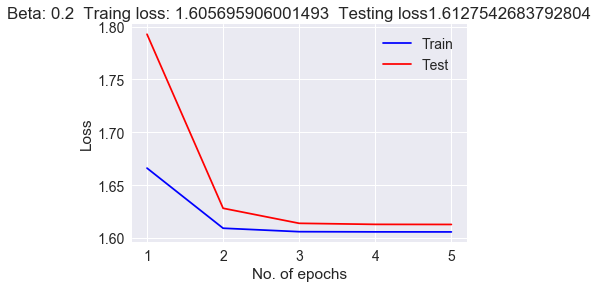

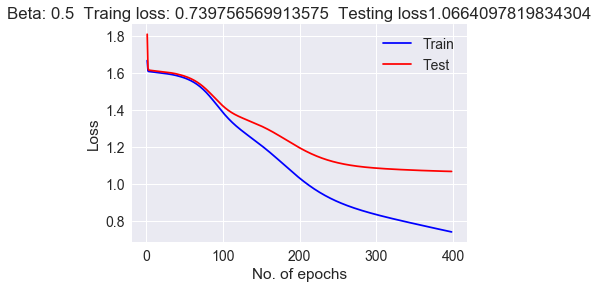

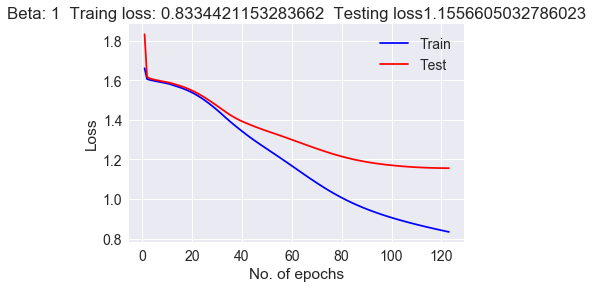

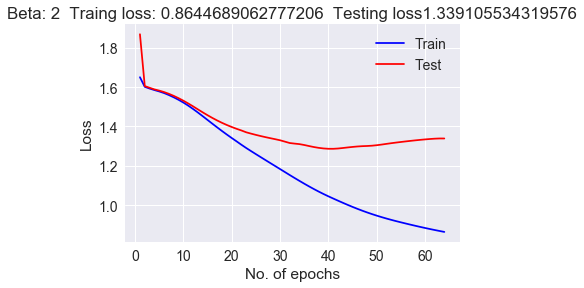

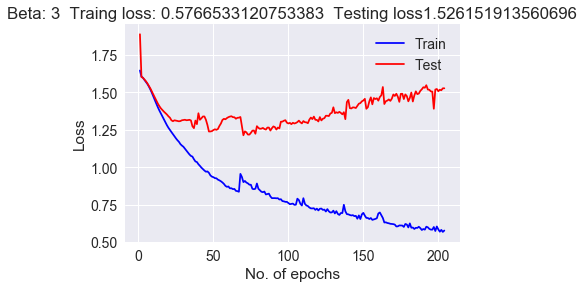

In [81]:
############################### BASE LINE ######################################
###############################  SMALL ################################
i = 1
for beta in beta_list:
    np.random.seed(1)
    var = np.sqrt(2/(85))
    W1 = np.random.normal(0, var, (60, 25))
    b1 = np.random.normal(0, var, (1, 25 ))

    var = np.sqrt(2/(50))
    W2 = np.random.normal(0, var, (25, 25))
    b2 = np.random.normal(0, var, (1, 25))

    var = np.sqrt(2/(30))
    W3 = np.random.normal(0, var, (25, 5))
    b3 = np.random.normal(0, var, (1, 5 ))
    
    fig = plt.figure(i)
    NN = Neural_Network(W1,W2, W3, b1,b2,b3, "Logistic",beta, "Cross_entropy", "Delta_rule", 0.001)
    NN.Train("Pattern",X_train,y_train,X_test,y_test, 2000)
    plt.title("Beta: "+str(beta)+"  Traing loss: "+str(NN.loss_train[-1])+"  Testing loss"+str(NN.loss_test[-1]))
    
    i += 1

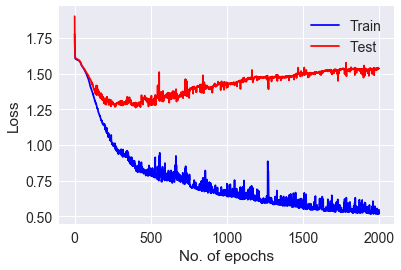

In [93]:
np.random.seed(1)
var = np.sqrt(2/(85))
W1 = np.random.normal(0, var, (60, 25))
b1 = np.random.normal(0, var, (1, 25 ))

var = np.sqrt(2/(50))
W2 = np.random.normal(0, var, (25, 25))
b2 = np.random.normal(0, var, (1, 25))

var = np.sqrt(2/(30))
W3 = np.random.normal(0, var, (25, 5))
b3 = np.random.normal(0, var, (1, 5 ))
NN = Neural_Network(W1,W2, W3, b1,b2,b3, "Logistic",10, "Cross_entropy", "Delta_rule", 0.0001)
NN.Train("Pattern",X_train,y_train,X_test,y_test, 2000)

Number of epochs for convergence = 296
Number of epochs for convergence = 177


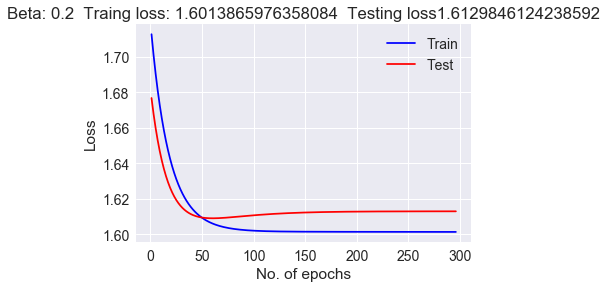

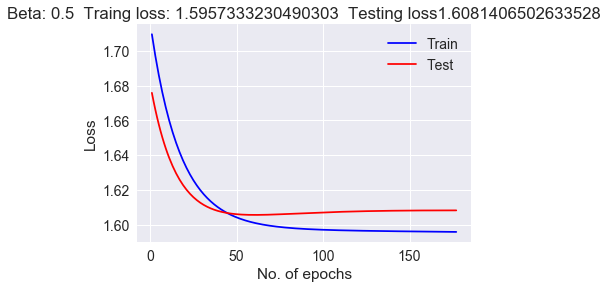

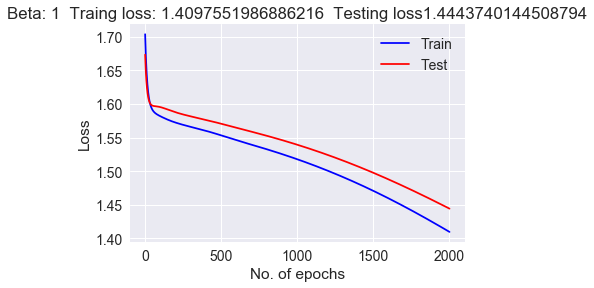

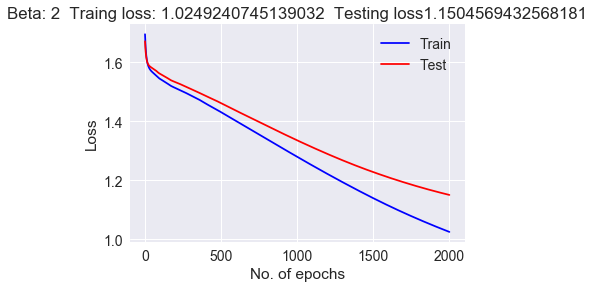

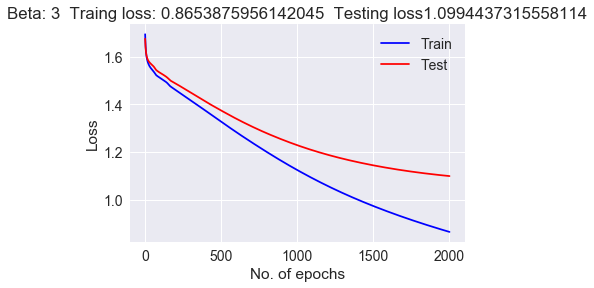

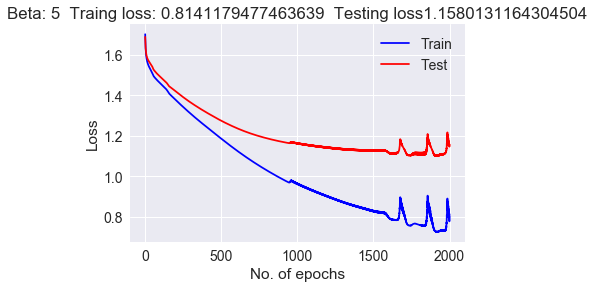

In [69]:
############################### BASE LINE ######################################
###############################  MEDIUM ################################
i = 1
for beta in beta_list:
    np.random.seed(2)
    var = np.sqrt(2/(110))
    W1 = np.random.normal(0, var, (60, 50))
    b1 = np.random.normal(0, var, (1, 50 ))

    var = np.sqrt(2/(100))
    W2 = np.random.normal(0, var, (50, 50))
    b2 = np.random.normal(0, var, (1, 50))

    var = np.sqrt(2/(55))
    W3 = np.random.normal(0, var, (50, 5))
    b3 = np.random.normal(0, var, (1, 5 ))
    
    fig = plt.figure(i)
    NN = Neural_Network(W1,W2, W3, b1,b2,b3, "Logistic",beta, "Cross_entropy", "Delta_rule", 0.001)
    NN.Train("Pattern",X_train,y_train,X_test,y_test, 2000)
    plt.title("Beta: "+str(beta)+"  Traing loss: "+str(NN.loss_train[-1])+"  Testing loss"+str(NN.loss_test[-1]))
    
    i += 1

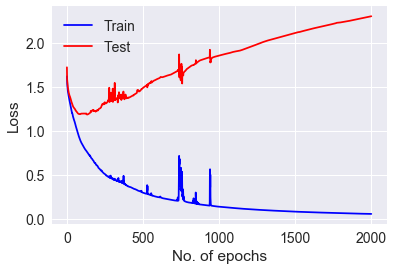

In [98]:
np.random.seed(2)
var = np.sqrt(2/(110))
W1 = np.random.normal(0, var, (60, 50))
b1 = np.random.normal(0, var, (1, 50 ))

var = np.sqrt(2/(100))
W2 = np.random.normal(0, var, (50, 50))
b2 = np.random.normal(0, var, (1, 50))

var = np.sqrt(2/(55))
W3 = np.random.normal(0, var, (50, 5))
b3 = np.random.normal(0, var, (1, 5 ))

NN = Neural_Network(W1,W2, W3, b1,b2,b3, "Logistic",10, "Cross_entropy", "Delta_rule", 0.0001)
NN.Train("Pattern",X_train,y_train,X_test,y_test, 2000)

Number of epochs for convergence = 3
Number of epochs for convergence = 295
Number of epochs for convergence = 82
Number of epochs for convergence = 40


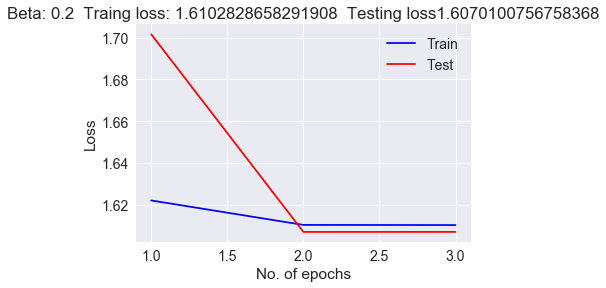

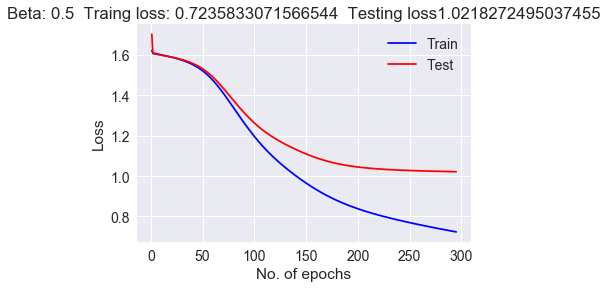

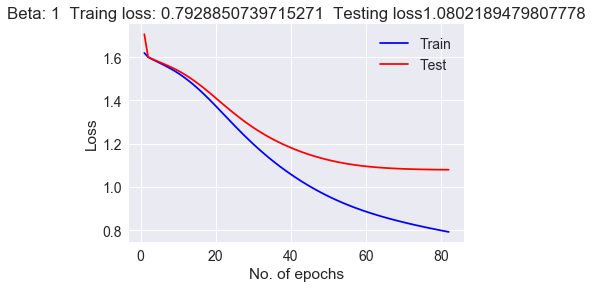

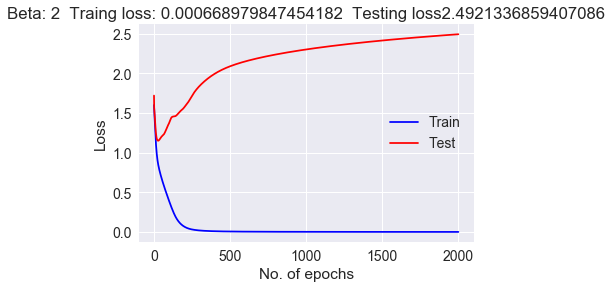

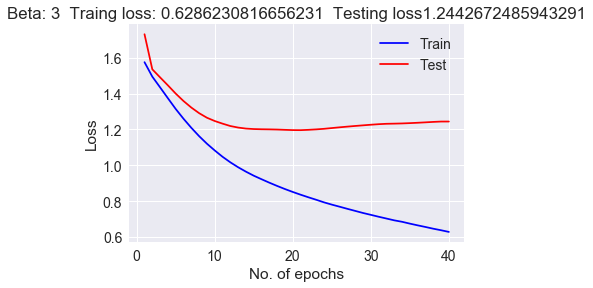

In [79]:
############################### BASE LINE ######################################
###############################  LARGE ########################################
i = 1
for beta in beta_list:
    np.random.seed(3)
    var = np.sqrt(2/(160))
    W1 = np.random.normal(0, var, (60, 100))
    b1 = np.random.normal(0, var, (1, 100 ))

    var = np.sqrt(2/(200))
    W2 = np.random.normal(0, var, (100, 100))
    b2 = np.random.normal(0, var, (1, 100))

    var = np.sqrt(2/(105))
    W3 = np.random.normal(0, var, (100, 5))
    b3 = np.random.normal(0, var, (1, 5 ))
    
    fig = plt.figure(i)
    NN = Neural_Network(W1,W2, W3, b1,b2,b3, "Logistic",beta, "Cross_entropy", "Delta_rule", 0.001)
    NN.Train("Pattern",X_train,y_train,X_test,y_test, 2000)
    plt.title("Beta: "+str(beta)+"  Traing loss: "+str(NN.loss_train[-1])+"  Testing loss"+str(NN.loss_test[-1]))
    
    i += 1

Text(0.5,1,'  Traing loss: 0.007804633548392677  Testing loss2.421041943187677')

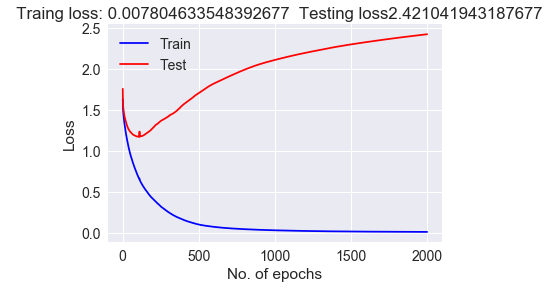

In [100]:
np.random.seed(2)
var = np.sqrt(2/(160))
W1 = np.random.normal(0, var, (60, 100))
b1 = np.random.normal(0, var, (1, 100 ))

var = np.sqrt(2/(200))
W2 = np.random.normal(0, var, (100, 100))
b2 = np.random.normal(0, var, (1, 100))

var = np.sqrt(2/(105))
W3 = np.random.normal(0, var, (100, 5))
b3 = np.random.normal(0, var, (1, 5 ))

NN = Neural_Network(W1,W2, W3, b1,b2,b3, "Logistic",10, "Cross_entropy", "Delta_rule", 0.0001)
NN.Train("Pattern",X_train,y_train,X_test,y_test, 2000)
plt.title("  Traing loss: "+str(NN.loss_train[-1])+"  Testing loss"+str(NN.loss_test[-1]))

In [101]:
optimizers_list =  ["Delta_rule", "Generalized_delta","Ada_grad","RMS_prop","Adam"]

Number of epochs for convergence = 572


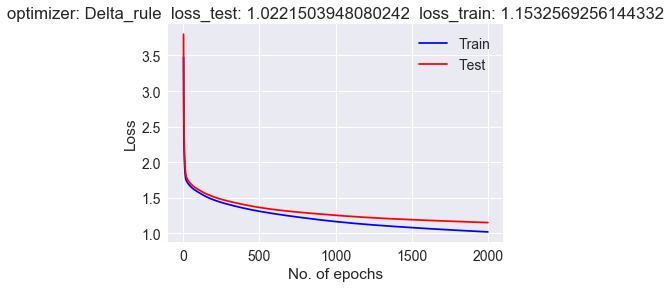

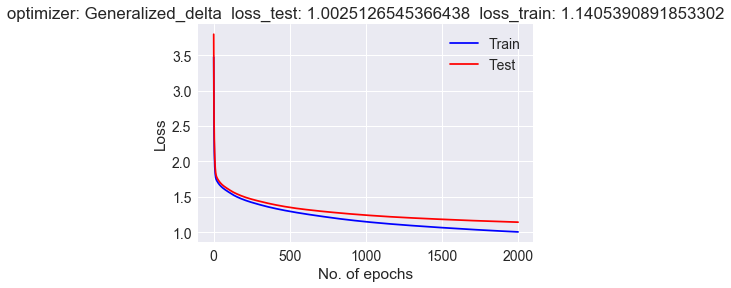

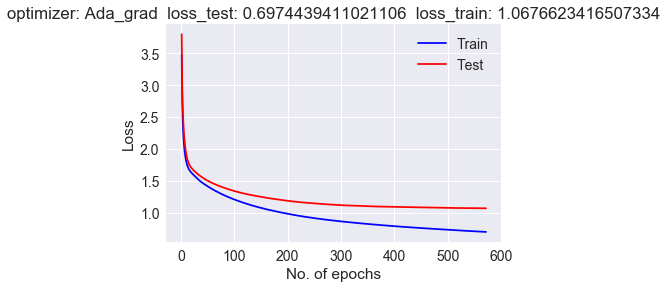

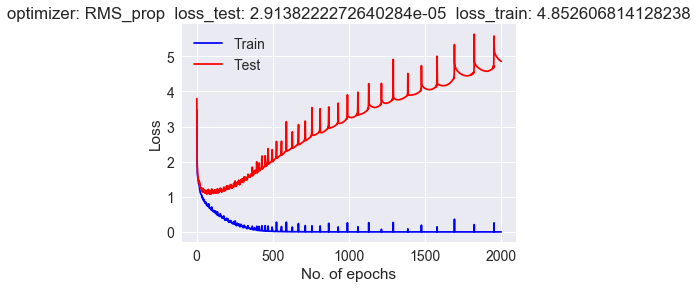

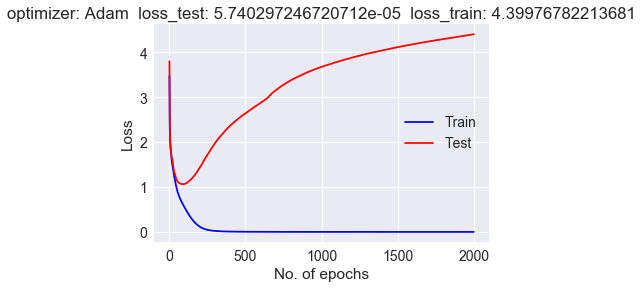

In [88]:
i = 1
for optimizer in optimizers_list:
    np.random.seed(3)
    var = np.sqrt(2/(160))
    W1 = np.random.normal(0, var, (60, 100))
    b1 = np.random.normal(0, var, (1, 100 ))

    var = np.sqrt(2/(200))
    W2 = np.random.normal(0, var, (100, 100))
    b2 = np.random.normal(0, var, (1, 100))

    var = np.sqrt(2/(105))
    W3 = np.random.normal(0, var, (100, 5))
    b3 = np.random.normal(0, var, (1, 5 ))
    plt.figure(i)
    NN = Neural_Network(W1,W2, W3, b1,b2,b3, "ReLU",beta, "Cross_entropy", optimizer, 0.001)
    NN.Train("Batch",X_train,y_train,X_test,y_test, 2000)
    plt.title('optimizer: '+str(optimizer) + "  loss_test: " + str(NN.loss_train[-1]) + "  loss_train: "+str(NN.loss_test[-1]))
    i+=1

In [63]:
def heat_map(X_train,y_train):
    import seaborn as sn
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    
    y_hat_train = NN.predict(X_train) 
    y_given_train = np.argmax(y_train, axis = 1)
    cm =confusion_matrix(y_given_train,y_hat_train)

    df_cm = pd.DataFrame(cm, index=["coast","forest","insidecity","mountain","street"], 
                         columns=["coast","forest","insidecity","mountain","street"])
    
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, cmap="YlGnBu",annot=True,annot_kws={"size": 12})